# Variational Autoencoder (VAE)

Useful links:
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset [http://vis-www.cs.umass.edu/lfw/](http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [2]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.initializers as I
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# The following code fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset

data, attrs = fetch_lfw_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [4]:
print(attrs.shape)
print(data.shape)
attrs.head()

(13143, 73)
(13143, 45, 45, 3)


,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,-1.273512,-1.431462,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,-1.889111,-1.857213,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.08268,-0.439614,-0.359859,-0.760774,-0.410152


In [5]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [6]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [7]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

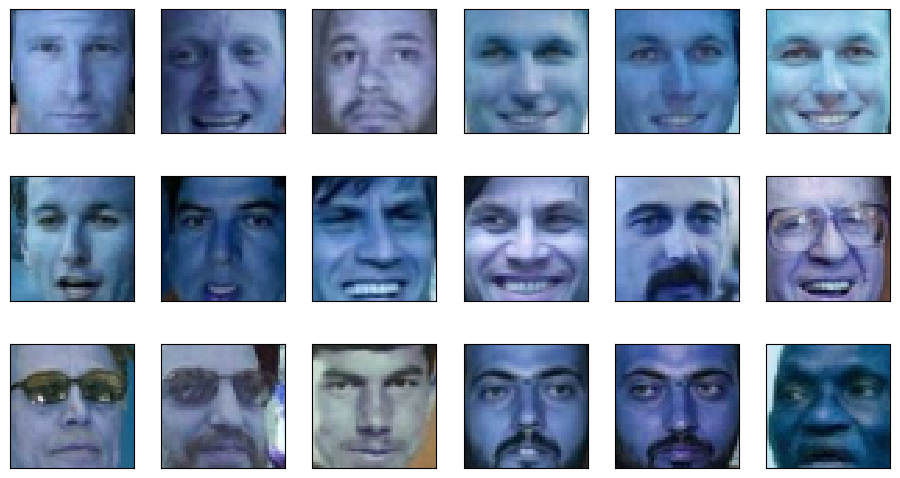

In [8]:
plot_gallery(X_train, image_h, image_w)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:


<img src="/content/Autoencoder_structure.jpg">

In [9]:
dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?

# You can define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

# However, you can just have 1 fc layer in each network without any activation,
# and it will also show some results

vanila_encoder = tf.keras.Sequential()
vanila_encoder.add(L.Dense(4*dimZ, activation='relu', kernel_initializer=I.GlorotUniform()))
vanila_encoder.add(L.Dense(dimZ, kernel_initializer=I.GlorotUniform()))
vanila_decoder = tf.keras.Sequential()
vanila_decoder.add(L.Dense(4*dimZ, activation='relu', kernel_initializer=I.GlorotUniform()))
vanila_decoder.add(L.Dense(X_train.shape[1], activation='sigmoid', kernel_initializer=I.GlorotUniform()))

model = tf.keras.Sequential()
model.add(vanila_encoder)
model.add(vanila_decoder)

In [10]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, rate):
        super(DisplayCallback, self).__init__()
        self.model = model
        self.rate = rate

    def on_epoch_end(self, epoch, logs=None):
        model = self.model
        if epoch % self.rate == 0:
            idx = np.random.choice(X_train.shape[0])
            plt.subplot(221)
            plt.imshow(X_train[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(222)
            plt.imshow(tf.reshape(
                model(X_train[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            idx = np.random.choice(X_val.shape[0])
            plt.subplot(223)
            plt.imshow(X_val[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(224)
            plt.imshow(tf.reshape(
                model(X_val[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            plt.show()

In [11]:
# Create MSE loss function
loss = tf.keras.losses.mean_squared_error
# Use Adam optimizer
opt = tf.keras.optimizers.Adam()
model.compile(loss=loss, optimizer=opt)
callback = DisplayCallback(model, 10)

In [12]:
model.build(input_shape=X_train.shape)

Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.0060

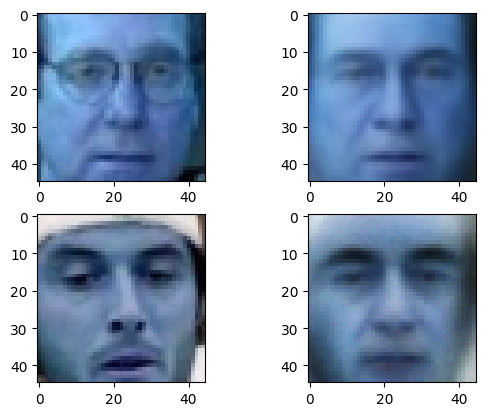

313/313 [==============================] - 28s 90ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 2/10
313/313 [==============================] - 25s 79ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 3/10
313/313 [==============================] - 24s 78ms/step - loss: 0.0053 - val_loss: 0.0062
Epoch 4/10
313/313 [==============================] - 26s 83ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 5/10
313/313 [==============================] - 24s 78ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 6/10
313/313 [==============================] - 24s 78ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 7/10
313/313 [==============================] - 24s 78ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 8/10
313/313 [==============================] - 24s 78ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 9/10
313/313 [==============================] - 24s 76ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 10/10
313/313 [==============================] - 24s 77ms/step - loss: 0.0044 - val_los

In [14]:
# Train your autoencoder
# Add validation data
# Visualize progress in reconstruction and loss decay
history = model.fit(
    X_train, X_train,
    epochs=10,
    validation_data = (X_val, X_val),
    callbacks=[callback]
)

Plot your loss values (also metrics, if you used them) for train and validation data

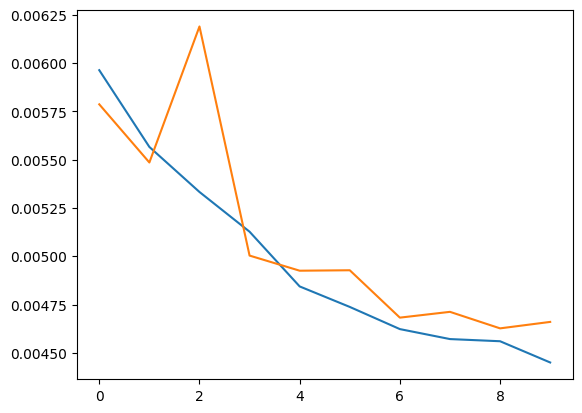

In [17]:
plt.plot(np.arange(10), history.history['loss'])
plt.plot(np.arange(10), history.history['val_loss'])
plt.show()

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

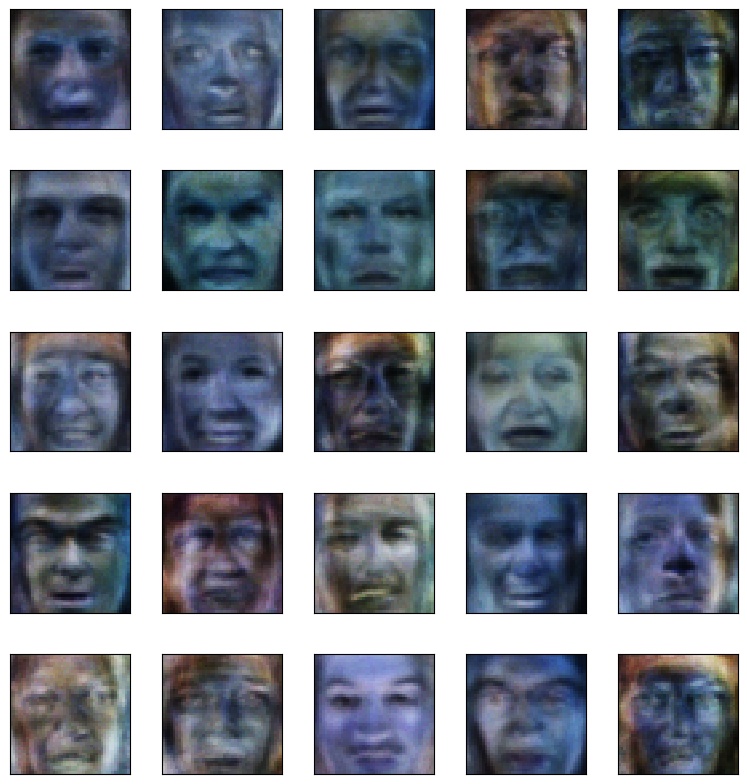

In [18]:
z = np.random.randn(25, dimZ)
output = vanila_decoder(z).numpy()
plot_gallery(output, image_h, image_w, n_row=5, n_col=5)

# Homework: Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler**, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [19]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 100

# define the network
# you can start from pytorch example https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

en_inputs = tf.keras.Input(shape = (X_train.shape[1],))

x = L.Dense(256, activation='relu',  kernel_initializer=I.GlorotUniform())(en_inputs)
x = L.Dense(128, activation='relu',  kernel_initializer=I.GlorotUniform())(x)

mean = L.Dense(dimZ,  kernel_initializer=I.GlorotUniform())(x)
variance = L.Dense(dimZ, kernel_initializer=I.GlorotUniform())(x)
sample = L.Lambda(lambda z: z[0] + tf.random.normal(tf.shape(z[0])) * tf.exp(0.5 * z[1]))([mean, variance])


encoder = tf.keras.Model(en_inputs, [mean, variance, sample])# output should be mean, variance and a sample

de_inputs = tf.keras.Input(shape = (dimZ,))
x = L.Dense(128, activation='relu',  kernel_initializer=I.GlorotUniform())(de_inputs)
x = L.Dense(256, activation='relu',  kernel_initializer=I.GlorotUniform())(x)
output = L.Dense(X_train.shape[1], activation = 'sigmoid',kernel_initializer=I.GlorotUniform())(x)
decoder = tf.keras.Model(de_inputs, output)

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

In [20]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    @tf.function
    def KL_divergence(self, mu, logsigma):
      return tf.reduce_mean(-0.5 * tf.reduce_sum(1 + logsigma - tf.square(mu) - tf.exp(logsigma), axis = -1))

    @tf.function
    def log_likelihood(self, x, z):
      recons_x = self.decoder(z)
      return tf.reduce_mean(tf.reduce_sum(tf.square(x - recons_x), axis=-1))


    def train_step(self, data):

      x = data

      with tf.GradientTape() as tape:
        mu, logsigma, z = self.encoder(x)

        kl_loss = self.KL_divergence(mu, logsigma)
        log_likelihood = self.log_likelihood(x,z)

        total_loss = tf.reduce_mean(kl_loss + log_likelihood)

      gradients = tape.gradient(total_loss, self.trainable_variables)
      self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
      return {
            "loss": total_loss,
            "kl_loss": kl_loss,
            "log_likelihood": log_likelihood
        }

    def call(self, inputs):
      mu, logsigma, z = self.encoder(inputs)
      reconstructed_inputs = self.decoder(z)
      return reconstructed_inputs

In [21]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
callback = DisplayCallback(vae, 2)

In [22]:
vae.build(input_shape=X_train.shape)

And train the model:

Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 174.5080 - kl_loss: 0.7857 - log_likelihood: 173.7223

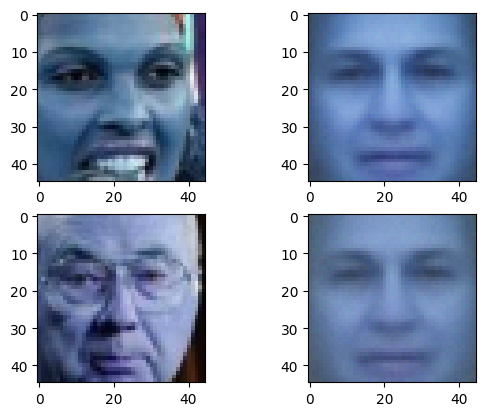

313/313 [==============================] - 20s 60ms/step - loss: 174.4912 - kl_loss: 0.7832 - log_likelihood: 173.7079 - val_loss: 0.0000e+00
Epoch 2/10
313/313 [==============================] - 16s 52ms/step - loss: 161.9611 - kl_loss: 0.0095 - log_likelihood: 170.5199 - val_loss: 0.0000e+00
Epoch 3/10
312/313 [============================>.] - ETA: 0s - loss: 175.6083 - kl_loss: 0.0072 - log_likelihood: 170.3002

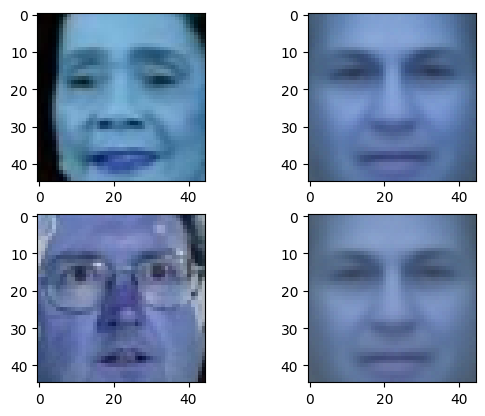

313/313 [==============================] - 16s 51ms/step - loss: 203.3434 - kl_loss: 0.0072 - log_likelihood: 170.5106 - val_loss: 0.0000e+00
Epoch 4/10
313/313 [==============================] - 15s 49ms/step - loss: 200.9217 - kl_loss: 0.0052 - log_likelihood: 170.1762 - val_loss: 0.0000e+00
Epoch 5/10
312/313 [============================>.] - ETA: 0s - loss: 169.5705 - kl_loss: 0.0040 - log_likelihood: 169.9030

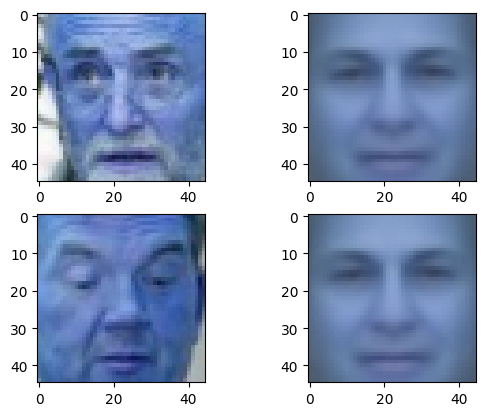

313/313 [==============================] - 16s 51ms/step - loss: 148.5574 - kl_loss: 0.0040 - log_likelihood: 169.7670 - val_loss: 0.0000e+00
Epoch 6/10
313/313 [==============================] - 15s 49ms/step - loss: 206.9231 - kl_loss: 0.0030 - log_likelihood: 169.8938 - val_loss: 0.0000e+00
Epoch 7/10
313/313 [==============================] - ETA: 0s - loss: 169.2691 - kl_loss: 0.0030 - log_likelihood: 169.6076

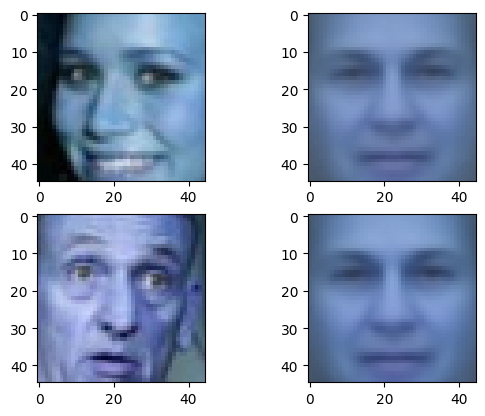

313/313 [==============================] - 19s 59ms/step - loss: 169.2691 - kl_loss: 0.0030 - log_likelihood: 169.6065 - val_loss: 0.0000e+00
Epoch 8/10
313/313 [==============================] - 28s 89ms/step - loss: 193.2090 - kl_loss: 0.0034 - log_likelihood: 169.6356 - val_loss: 0.0000e+00
Epoch 9/10
313/313 [==============================] - ETA: 0s - loss: 169.1870 - kl_loss: 0.0027 - log_likelihood: 169.4664

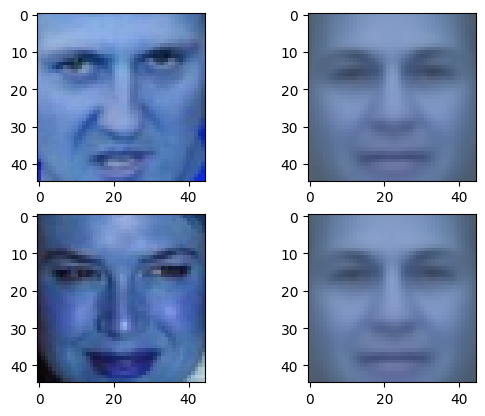

313/313 [==============================] - 28s 89ms/step - loss: 169.1870 - kl_loss: 0.0027 - log_likelihood: 169.4655 - val_loss: 0.0000e+00
Epoch 10/10
313/313 [==============================] - 17s 53ms/step - loss: 143.1245 - kl_loss: 0.0028 - log_likelihood: 169.3815 - val_loss: 0.0000e+00


In [23]:
history = vae.fit(X_train, epochs = 10, validation_data = (X_val, X_val), callbacks=[callback]
)

Plot the learning curves

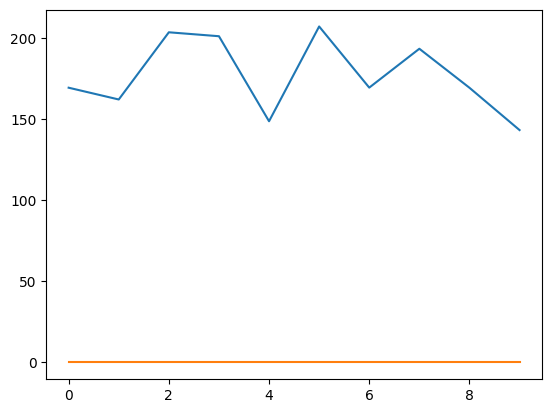

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

And finally sample from VAE.

In [ ]:
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))

1/1 [==============================] - 0s 149ms/step


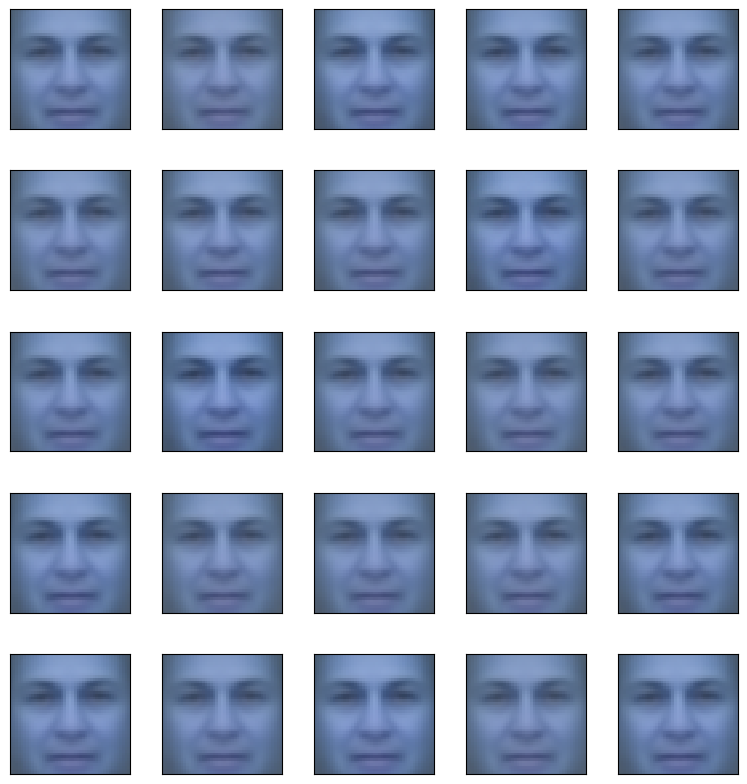

In [25]:
z = np.random.randn(25, dimZ)
output = vae.decoder.predict(z)
plot_gallery(output, image_h, image_w, n_row=5, n_col=5)

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it.

# Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE.

<img src="linear.png" alt="linear">

In [ ]:
# your code here

Vanila autoencoders are not suitable for this task